In [1]:
pip install --pre mlflow

Note: you may need to restart the kernel to use updated packages.


Note: you may need to restart the kernel to use updated packages.


In [124]:
import mlflow
from mlflow.models import infer_signature

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, accuracy_score, precision_score, recall_score, f1_score, r2_score

In [194]:
#Load data
df = pd.read_csv('hamilton_zip_merge__hamilton_20250413_184944__redfin_20250413_212311__created_20250413_213235.csv')

#Define target and features
target = 'Estimated_Days_On_Market'  # replace with actual column name
df = df.dropna(subset=['saleamount', 'Year Built', '# Bedrooms', '# Full Bathrooms','Acreage', 'Finished Square Footage','Estimated_Days_On_Market']) #drop incomplete rows
X = df.drop(columns=[target])
y = df[target]

#Identify categorical and numerical columns
numeric_cols = X.iloc[:, [18, 26, 28, 29]]
numeric_cols = numeric_cols.select_dtypes(include=['number']).columns.tolist()  # This gives a list of column names
print(numeric_cols)

#Preprocessing: One-hot encode categorical columns
#preprocessor = ColumnTransformer(
#    transformers=[
#        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
#    ],
#    remainder='passthrough'  # Keep numeric columns as they are
#)

X_train, X_val, y_train, y_val = train_test_split(X[numeric_cols], y, test_size=0.1, random_state=42)


# Define the model hyperparameters
params = {
    "random_state": 42,
    "max_depth": 8,
    "min_samples_leaf": 4,
}

#Create a pipeline: scale features and train a decision tree regressor
model = Pipeline(steps=[('regressor', DecisionTreeRegressor(**params))])

#Train the model
model.fit(X_train, y_train)

#Predict and evaluate
preds = model.predict(X_val)
mae = mean_absolute_error(y_val, preds)
r2 = r2_score(y_val, preds)

print(f'Mean Absolute Error: {mae:.2f}')
print(y_val)
print(preds)
print(f'r_squared: {r2:.2f}')


['saleamount', 'Year Built', '# Bedrooms', '# Full Bathrooms']
Mean Absolute Error: 14.81
81    64.0
77    50.0
0     65.0
58    40.0
8     48.0
47    48.0
23    65.0
Name: Estimated_Days_On_Market, dtype: float64
[49.2  62.4  45.5  54.4  62.4  62.4  51.25]
r_squared: -1.50


# Manual Tuning for DEV ONLY

In [189]:
#regressor = DecisionTreeRegressor(max_depth=8, min_samples_leaf=2, random_state=42)
#
#model = Pipeline(steps=[('regressor', regressor)])
#
#model.fit(X_train, y_train)
#preds = model.predict(X_val)
#mae = mean_absolute_error(y_val, preds)
#print(f'Tuned MAE: {mae:.2f}')
#print(preds)

# Visualizer

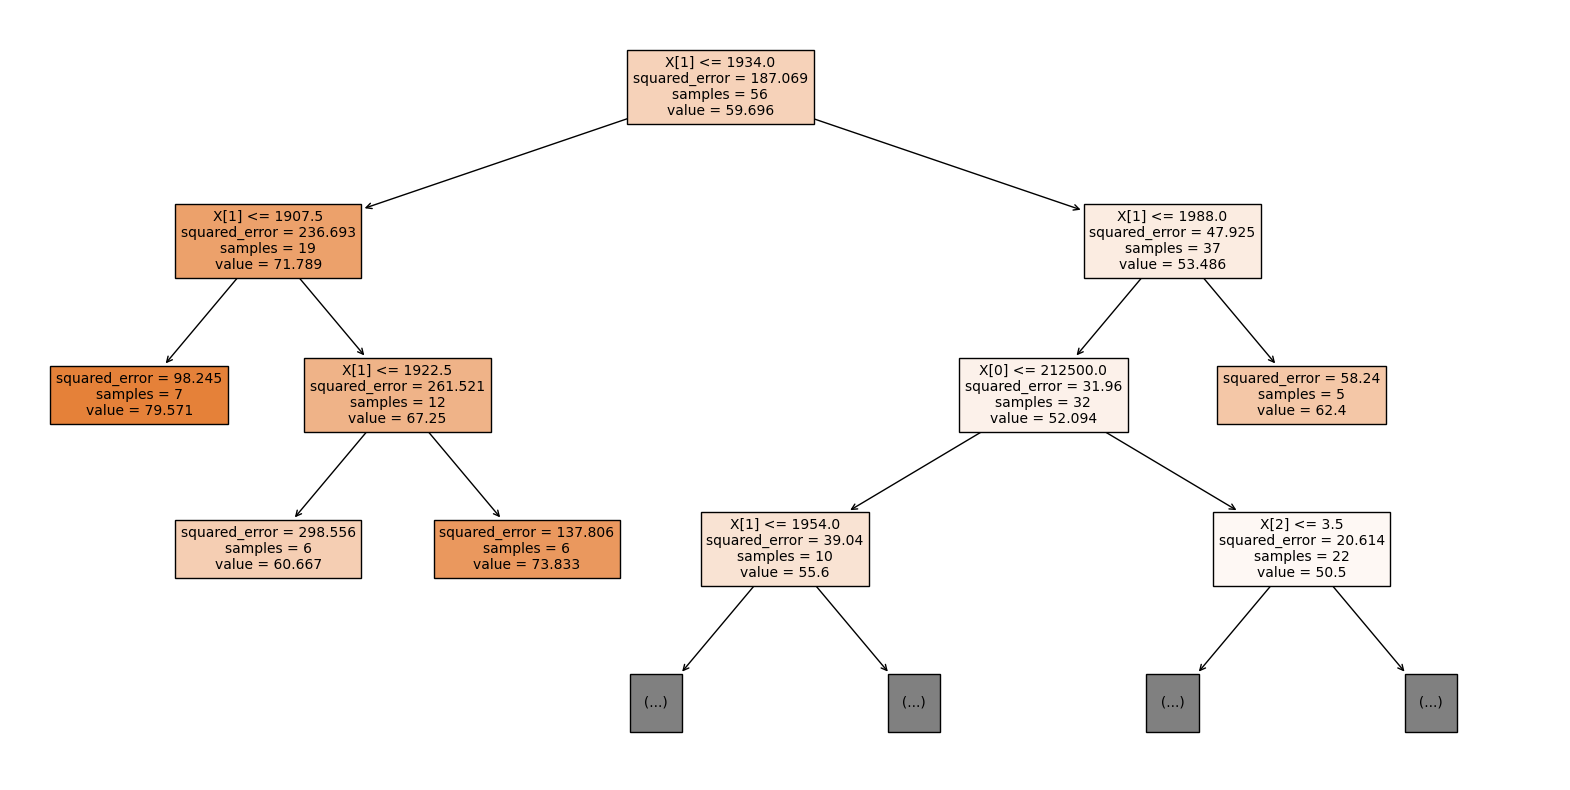

In [190]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

# Access the trained decision tree from the pipeline
regressor = model.named_steps['regressor']

# Plot it
plt.figure(figsize=(20,10))
plot_tree(
    regressor,
    filled=True,
    fontsize=10,
    max_depth=3  # limit depth for readability
)
plt.show()


# ML Flow Log

In [16]:
mlflow.set_tracking_uri(uri="http://<host>:<port>")

In [195]:
# Set our tracking server uri for logging
mlflow.set_tracking_uri(uri="http://127.0.0.1:8080")

# Create a new MLflow Experiment
mlflow.set_experiment("Machine Learning Design Group 1")

# Start an MLflow run
with mlflow.start_run():
    # Log the hyperparameters
    mlflow.log_params(params)

    # Log the loss metric
    mlflow.log_metric("r_squared", r2)
    mlflow.log_metric("Mean Absolute Error", mae)


    # Set a tag that we can use to remind ourselves what this run was for
    mlflow.set_tag("MVP", "First test of ML Flow with model")

    # Infer the model signature
    signature = infer_signature(X_train, model.predict(X_train))

    # Log the model
    model_info = mlflow.sklearn.log_model(
        sk_model=model,
        artifact_path="housing_model",
        signature=signature,
        input_example=X_train,
        registered_model_name="DOM-predictor",
    )

C:\Users\schri\anaconda3\lib\site-packages\mlflow\types\utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
2025/04/13 22:51:31 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: C:\Users\schri\AppData\Local\Temp\tmpnexr8ybp\model\model.pkl, flavor: sklearn). Fall back to return ['scikit-lear

Registered model 'DOM-predictor' already exists. Creating a new version of this model...
2025/04/13 22:51:31 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: DOM-predictor, version 7


🏃 View run upset-jay-61 at: http://127.0.0.1:8080/#/experiments/1/runs/49d6348644844ed78efb6b46c078bc18
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/1


Created version '7' of model 'DOM-predictor'.


# Load the Model

In [ ]:
# Load the model back for predictions as a generic Python Function model
loaded_model = mlflow.pyfunc.load_model(model_info.model_uri)

predictions = loaded_model.predict(X_test)

iris_feature_names = datasets.load_iris().feature_names

result = pd.DataFrame(X_test, columns=iris_feature_names)
result["actual_class"] = y_test
result["predicted_class"] = predictions

result[:4]